In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import decomposition
import sys
import torch
import umap

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import s1_direct_product_decoder, geometry_util

2023-01-18 16:06:11.076921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 16:06:11.222638: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-18 16:06:11.701251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-18 16:06:11.701289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device {}".format(device))

using device cuda


First load in the data. This was generated from raw spikes using the preprocessing notebook located in the same folder as this one. Spikes were simply convolved with a Gaussian kernel to produce rates, as standard.

In [3]:
data_dir = "/home/trevor/manifold_test_data/torus/gardner_data/10k_bins"
all_data = np.load(os.path.join(data_dir, "all_mod_encoded_points.npy"), allow_pickle=True)
data = np.transpose(all_data[-1])

Do some linear dimensionality reduction to make things easier. The solution doesnt seem to sensitive to this. They use 6 in the original paper.

In [4]:
pca_instance = decomposition.PCA(n_components=8)
proj_data = pca_instance.fit_transform(np.sqrt(data))
normed_rates = proj_data/np.mean(np.abs(proj_data))

Now find the Torus.

In [5]:
decoder_hidden_size = 1000
encoder_hidden_size = int(1.5 * decoder_hidden_size)
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [17]:
encoder, decoder = s1_direct_product_decoder.train(data=normed_rates, manifold_dim=2, device=device,
                                                   n_training_iterations=5000, decoder_weight=1, order_red_weight=1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.6248573064804077, distance cost: 0.040623247623443604, order reduction: 0.010999064892530441
iteration: 4, decoding loss: 1.5022900104522705, distance cost: 0.07642126828432083, order reduction: 0.015399605967104435
iteration: 5, decoding loss: 1.2489171028137207, distance cost: 0.0672268494963646, order reduction: 0.01757223904132843
iteration: 6, decoding loss: 1.2244991064071655, distance cost: 0.059772975742816925, order reduction: 0.014122416265308857
iteration: 7, decoding loss: 1.150522232055664, distance cost: 0.05512189120054245, order reduction: 0.015661047771573067
iteration: 8, decoding loss: 1.0953102111816406, distance cost: 0.051054880023002625, order reduction: 0.01549796387553215
iteration: 9, decoding loss: 1.032584547996521, distance cost: 0.0462753102183342, order reduction: 0.01575867272913456
iteration: 10, decoding loss: 1.012685775756836, distance cost: 0.02826627902686596, order reduction: 0.015831977128982544
iteration: 11, decod

We can plot some 2D projections. It will be hard to interpret these, as the manifod we have found is 2D. I am mainly looking at the shapes of the data and detected manifold to see if they line up. This isn't that useful.

In [18]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [19]:
test_angles = np.random.uniform(0, 2 * np.pi, (1000, 2))
test_points = geometry_util.angles_to_ring(test_angles)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(test_points, dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


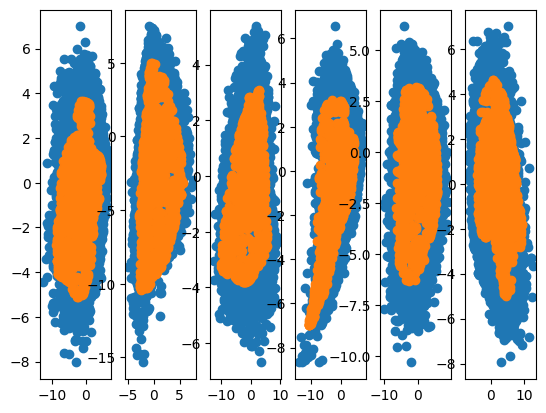

In [20]:
%matplotlib inline
data_plot_density = 1
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].scatter(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


Now we will try and form a 3D visualization of the fit manifold. I'll use UMAP to generate a random 3D embedding. If we're lucky it will have a hole in it.

In [21]:
embedding_fn = umap.UMAP(n_components=3, n_neighbors=5)
embedding_fn.fit(proj_data)


UMAP(n_components=3, n_neighbors=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [22]:
isomapped_data = embedding_fn.transform(proj_data)


Now i'll generate some traces of the identified manifold. I do this by sparsely sampling the first phase and densely sampling the second, then plot lines constant in the first phase.

In [23]:
outer_angles = np.arange(start=0, stop=2*np.pi, step=0.5)
inner_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
all_surface_data = []
for angle in outer_angles:
    test_angles = np.zeros((1000,2))
    test_angles[:, 0] = inner_angles
    test_angles[:, 1] = angle
    all_surface_data.append(test_angles)
all_surface_data = np.stack(all_surface_data)
all_surface_data_flat = np.reshape(all_surface_data, (-1, 2))

with torch.no_grad():
    surface_points = encoder(torch.tensor(geometry_util.angles_to_ring(all_surface_data_flat), dtype=torch.get_default_dtype()).to(device))
surface_points = surface_points.cpu().numpy()


In [24]:
isomapped_surface = embedding_fn.transform(surface_points)
isomapped_surface = np.reshape(isomapped_surface, (*np.shape(all_surface_data)[:-1], -1))


In [28]:
%matplotlib tk
proj_fig = plt.figure()
proj_axs = proj_fig.add_subplot(projection="3d")
plot_density = 1
proj_axs.scatter(isomapped_data[::plot_density, 0], isomapped_data[::plot_density, 1], isomapped_data[::plot_density, 2], alpha=0.1)
for i in range(np.shape(isomapped_surface)[0]):
    proj_axs.plot(isomapped_surface[i, :, 0], isomapped_surface[i, :, 1], isomapped_surface[i, :, 2])


The quality of the visualization generated by above varies alot depending on how well UMAP works. Here is an example of a good looking decoding:

[Decoding Image](https://drive.google.com/file/d/1CwZxeiNJRcGjWFkA3Fkg0GW20jooCN_V/view?usp=share_link)

The data and fit manifold have been distorted by UMAP, so the details of the manifold shape are meaningless. The important thing is that the identified manifold shares the hole present in the data!